# Galaxies, Stars and Quasars Classification

## Galaxies

A galaxy is a gravitationally bound system of stars, stellar remnants, interstellar gas, dust and dark matter. Galaxies are categorised according to their morphology: elliptical, spiral, irregular.

## Star

A luminous spheroid of plasma, generating energy through nuclear fusion at its core.

## Quasar

Quasar/Quasi-Stellar object, an extremely luminous active galactic nuclei (AGN), radiating lots of energy.


## Sloan Digital Sky Survey (SDSS) Data

Sloan Digital Sky Survey (SDSS), a large scale astronomical survey that ha mapped out the night sky.

The data consists of 10,000 observations taken by the SDSS mission. Every observation is described by 17 feature columns and 1 class column which identifies it to be either a star, galaxy, or quasar.

25% is used in testing the model performance and 75% is used in traiing the model.

## Ugriz Filter System

`u`, `g`, `r`, `i`, `z`, refers to a set of five optical filters used in astronomical imaging and `photometry` to measure the colors of stars and other celestial objects. These filters correspond to different wavelength ranges in the visible and near-infrared spectrum;
u=ultraviolet, g=green, r=red, i=near-infrared, z=far-infrared.

`Photometry` is the measurement of the brightness of celestial objects, usually through the use of specialized filters and detectors. The filters allow astronomers to study the properties and compositions of celestial object based on their observed colors. SDSS uses the `ugriz` filter system.

Having measured an objects brightness through these different filters, one can then determine their `color-index`.
`Color-index` is a measure of the difference in brightness between two filters.

The color indices derived from `ugriz` photometry are then used to infer for instance the surface temperature of a star or their other physical properties. They become essential when one needs to classify and identify different types of celestial objects - a fact we'll use to classify the different types of galaxies.

The ugriz system is particularly useful for studying the properties of distant galaxies, as the observed colors of these objects can provide information about their redshift, spectral type, luminosuty, stellar populations, and overall composition.

## Imports

In [ ]:
import pandas as pd
from pandas import DataFrame
from numpy import ndarray
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


In [1]:
dataframe: DataFrame = pd.read_csv(filepath_or_buffer="data.csv")

dataframe.info()

NameError: name 'pd' is not defined

### Data Cleanup

In [ ]:
# Check null values
dataframe.isnull().sum()

objid        0
ra           0
dec          0
u            0
g            0
r            0
i            0
z            0
run          0
rerun        0
camcol       0
field        0
specobjid    0
class        0
redshift     0
plate        0
mjd          0
fiberid      0
dtype: int64

In [ ]:
# Drop rows with negative magnitudes
dataframe = dataframe[dataframe['u'] > 0]
dataframe = dataframe[dataframe['g'] > 0]
dataframe = dataframe[dataframe['r'] > 0]
dataframe = dataframe[dataframe['i'] > 0]
dataframe = dataframe[dataframe['z'] > 0]

#Drop the object id columns, they are of no use in the analysis
dataframe.drop(['objid','specobjid'], axis=1, inplace=True)

dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ra        10000 non-null  float64
 1   dec       10000 non-null  float64
 2   u         10000 non-null  float64
 3   g         10000 non-null  float64
 4   r         10000 non-null  float64
 5   i         10000 non-null  float64
 6   z         10000 non-null  float64
 7   run       10000 non-null  int64  
 8   rerun     10000 non-null  int64  
 9   camcol    10000 non-null  int64  
 10  field     10000 non-null  int64  
 11  class     10000 non-null  object 
 12  redshift  10000 non-null  float64
 13  plate     10000 non-null  int64  
 14  mjd       10000 non-null  int64  
 15  fiberid   10000 non-null  int64  
dtypes: float64(8), int64(7), object(1)
memory usage: 1.2+ MB


In [ ]:
dataframe.head(3)

,ra,dec,u,g,r,i,z,run,rerun,camcol,field,class,redshift,plate,mjd,fiberid
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,STAR,-0.000009,3306,54922,491
1,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,STAR,-0.000055,323,51615,541
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,GALAXY,0.123111,287,52023,513


### Filter the Data

In [ ]:
# Define the important columns
important_columns: list[str] = ["ra", "dec", "u", "g", "r", "i", "z", "redshift"]

filtered_data: DataFrame = dataframe[important_columns].copy()

# Convert to the appropriate data types
filtered_data: DataFrame = filtered_data.astype({
    "ra": float,
    "dec": float,
    "u": float,
    "g": float,
    "r": float,
    "i": float,
    "z": float,
    "redshift": float
})

# Display the cleaned dataframe
print(filtered_data.dtypes)
filtered_data.head()

ra          float64
dec         float64
u           float64
g           float64
r           float64
i           float64
z           float64
redshift    float64
dtype: object


,ra,dec,u,g,r,i,z,redshift
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,-0.000009
1,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,-0.000055
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,0.123111
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,-0.000111
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,0.000590


### Create Color Indices

`u-g`, `r-i`, `g-r`

In [ ]:
filtered_data['u-g'] = filtered_data['u'] - filtered_data['g']
filtered_data['g-r'] = filtered_data['g'] - filtered_data['r']
filtered_data['r-i'] = filtered_data['r'] - filtered_data['i']
filtered_data['i-z'] = filtered_data['i'] - filtered_data['z']

filtered_data['u-r'] = filtered_data['u'] - filtered_data['r']

filtered_data.head()

,ra,dec,u,g,r,i,z,redshift,u-g,g-r,r-i,i-z,u-r
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,-0.000009,2.43166,1.09541,0.44357,0.27811,3.52707
1,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,-0.000055,1.44831,0.53812,0.18715,0.09772,1.98643
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,0.123111,1.19129,0.71741,0.38696,0.28607,1.90870
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,-0.000111,1.16264,0.44156,0.17883,0.07795,1.60420
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,0.000590,1.28683,-0.17527,-0.11623,-0.05834,1.11156


#### Include the target

Convert the class to numeric data i.e. encoding categorical features into numeric values.


In [ ]:
# Encode the 'class' column as integers
# filtered_data["class_label"] = dataframe["class"].astype('category').cat.codes

# Using Sklearn
# le: LabelEncoder = LabelEncoder().fit(dataframe['class'])
# dataframe['class'] = le.transform(dataframe['class'])

filtered_data['class_label'] = dataframe['class'].map({'STAR': 0, 'GALAXY': 1, 'QSO': 2})

# filtered_data['class'] = dataframe['class']

filtered_data.head()

,ra,dec,u,g,r,i,z,redshift,u-g,g-r,r-i,i-z,u-r,class_label
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,-0.000009,2.43166,1.09541,0.44357,0.27811,3.52707,0
1,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,-0.000055,1.44831,0.53812,0.18715,0.09772,1.98643,0
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,0.123111,1.19129,0.71741,0.38696,0.28607,1.90870,1
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,-0.000111,1.16264,0.44156,0.17883,0.07795,1.60420,0
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,0.000590,1.28683,-0.17527,-0.11623,-0.05834,1.11156,0


In [ ]:
filtered_data.isnull().sum()

ra             0
dec            0
u              0
g              0
r              0
i              0
z              0
redshift       0
u-g            0
g-r            0
r-i            0
i-z            0
u-r            0
class_label    0
dtype: int64

In [ ]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ra           10000 non-null  float64
 1   dec          10000 non-null  float64
 2   u            10000 non-null  float64
 3   g            10000 non-null  float64
 4   r            10000 non-null  float64
 5   i            10000 non-null  float64
 6   z            10000 non-null  float64
 7   redshift     10000 non-null  float64
 8   u-g          10000 non-null  float64
 9   g-r          10000 non-null  float64
 10  r-i          10000 non-null  float64
 11  i-z          10000 non-null  float64
 12  u-r          10000 non-null  float64
 13  class_label  10000 non-null  int64  
dtypes: float64(13), int64(1)
memory usage: 1.1 MB


## Exploratory Data Analysis

In [ ]:
# plt.figure(figsize=(20,21))
# # print(len(filtered_data.columns))
# for i, col in enumerate(filtered_data.columns, 0):
#     if i == len(filtered_data.columns)-1:
#         break
#     plt.subplot(4, 3, i)
#     sns.histplot(x=filtered_data[col])
#     plt.title(f"Histogram of `{col}` Data")
#     plt.xticks(rotation = 45)
#     plt.plot()


array([[<Axes: title={'center': 'ra'}>, <Axes: title={'center': 'dec'}>,
        <Axes: title={'center': 'u'}>, <Axes: title={'center': 'g'}>],
       [<Axes: title={'center': 'r'}>, <Axes: title={'center': 'i'}>,
        <Axes: title={'center': 'z'}>,
        <Axes: title={'center': 'redshift'}>],
       [<Axes: title={'center': 'u-g'}>, <Axes: title={'center': 'g-r'}>,
        <Axes: title={'center': 'r-i'}>, <Axes: title={'center': 'i-z'}>],
       [<Axes: title={'center': 'u-r'}>,
        <Axes: title={'center': 'class_label'}>, <Axes: >, <Axes: >]],
      dtype=object)

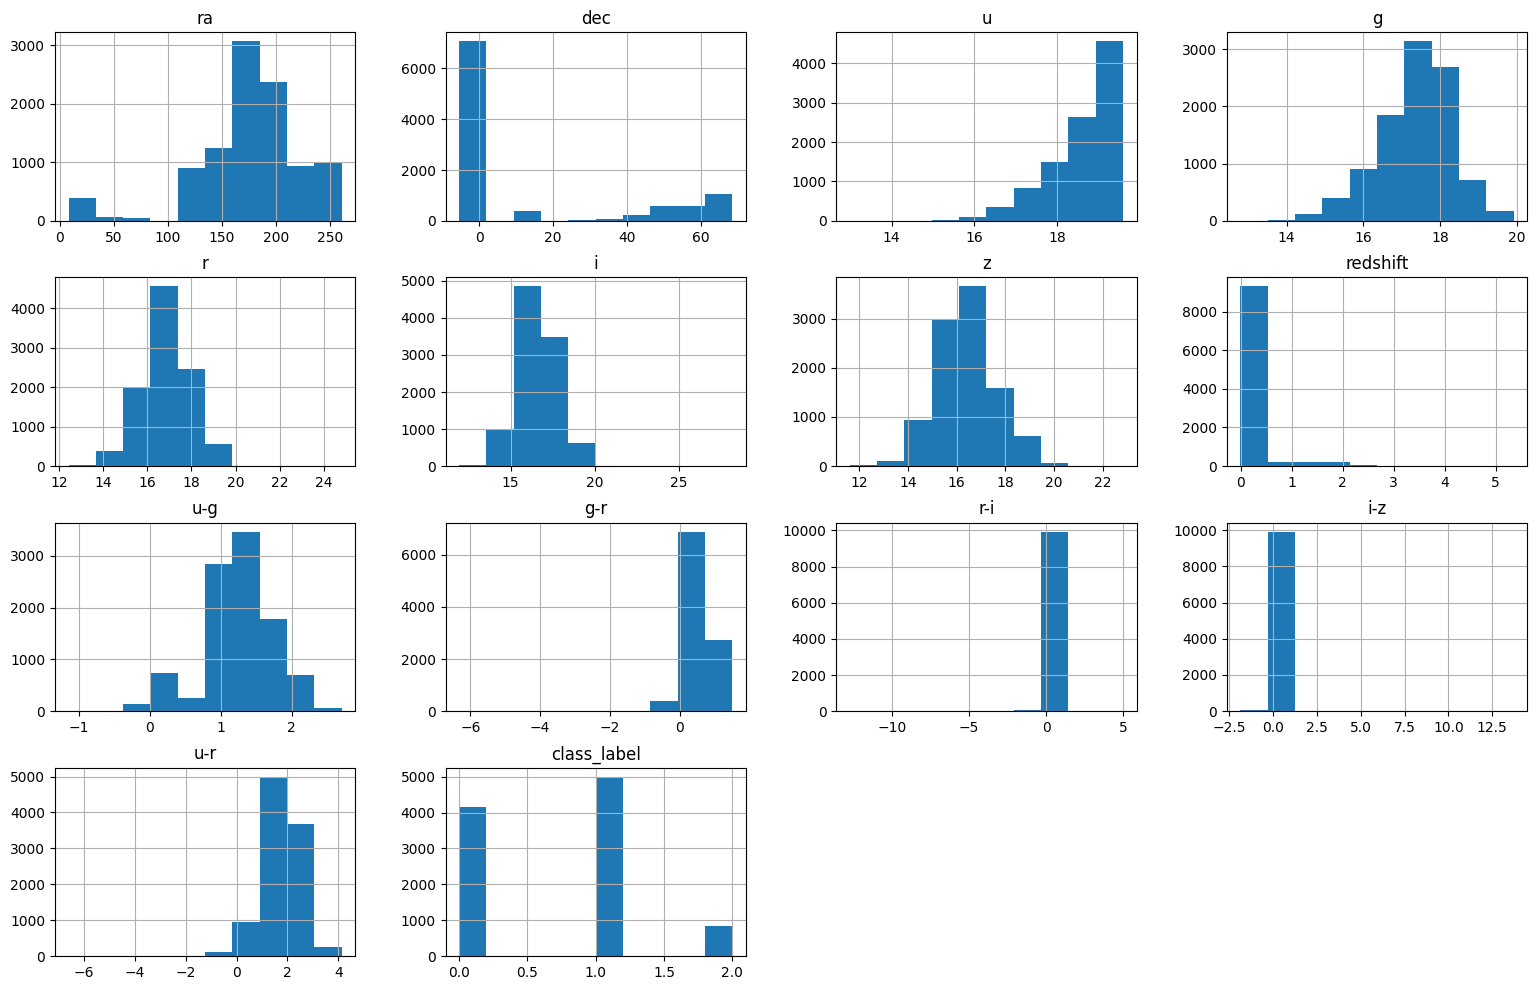

In [ ]:
filtered_data.hist(figsize=(19, 12))

### Color-Magnitude diagrams

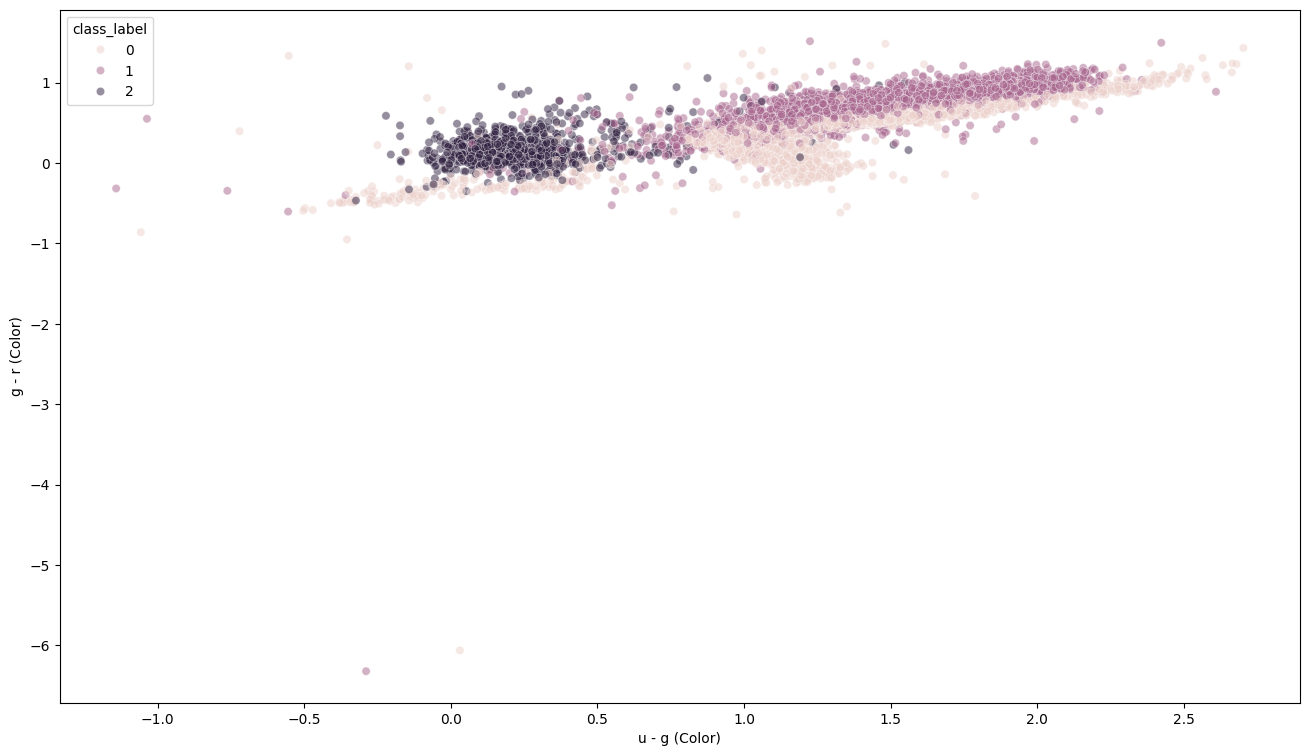

In [ ]:
plt.figure(figsize=(16,9))
sns.scatterplot(data=filtered_data, x='u-g', y='g-r', hue='class_label', alpha=0.5)

plt.xlabel('u - g (Color)')
plt.ylabel('g - r (Color)')
plt.show()

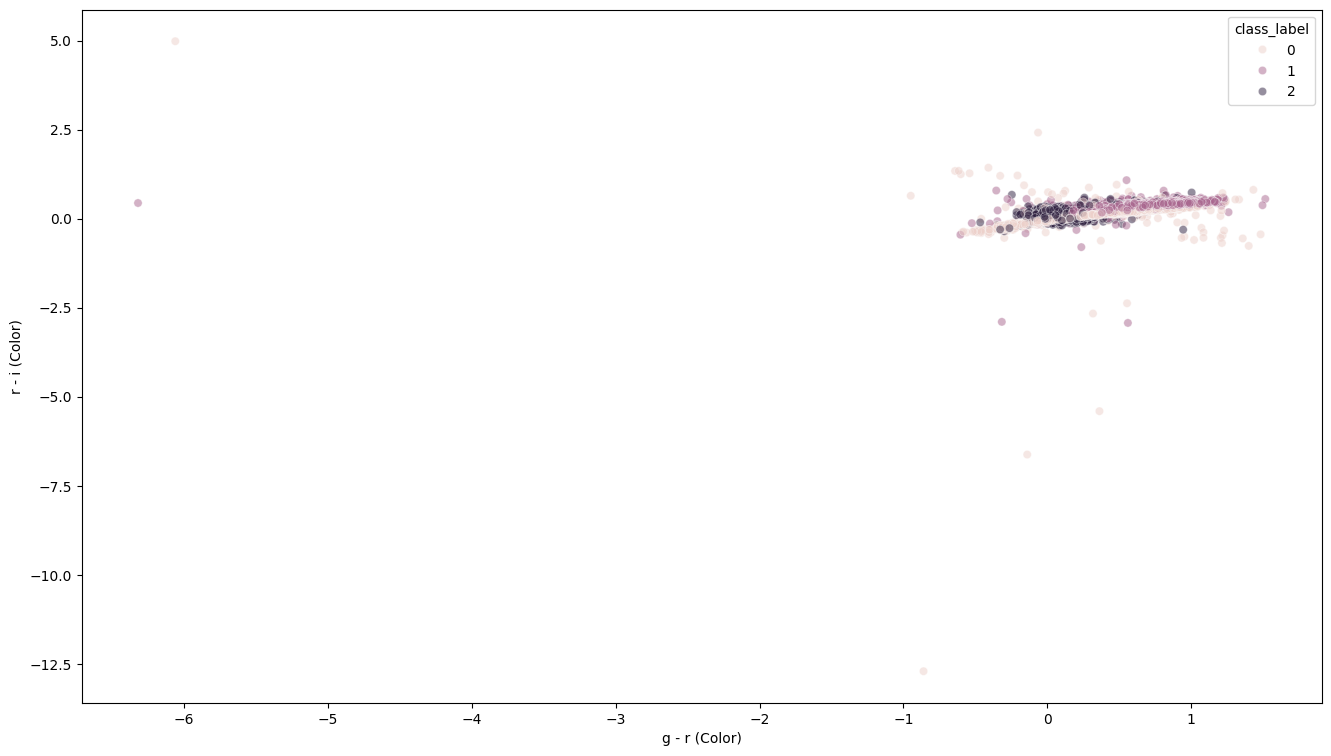

In [ ]:
plt.figure(figsize=(16,9))
sns.scatterplot(data=filtered_data, x='g-r', y='r-i', hue='class_label', alpha=0.5)

plt.xlabel('g - r (Color)')
plt.ylabel('r - i (Color)')
plt.show()

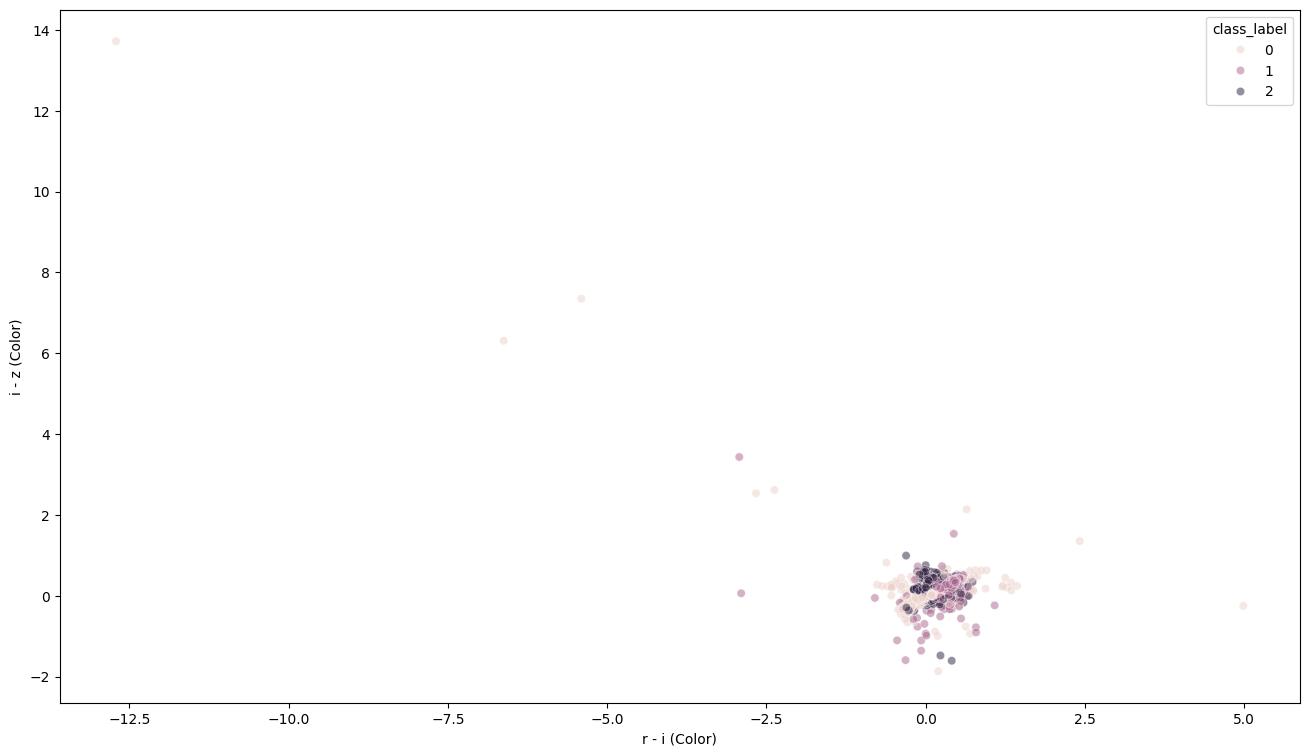

In [ ]:
plt.figure(figsize=(16,9))
sns.scatterplot(data=filtered_data, x='r-i', y='i-z', hue='class_label', alpha=0.5)

plt.xlabel('r - i (Color)')
plt.ylabel('i - z (Color)')
plt.show()

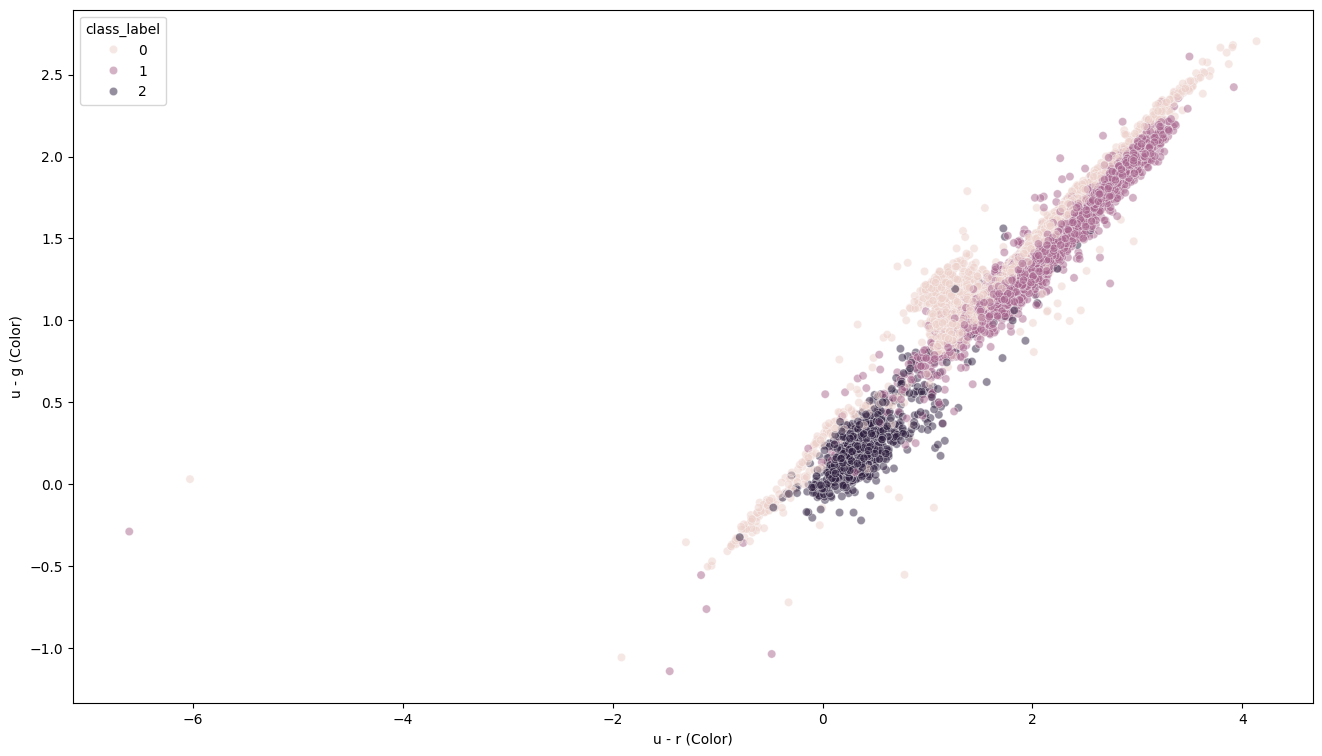

In [ ]:
plt.figure(figsize=(16,9))
sns.scatterplot(data=filtered_data, x='u-r', y='u-g', hue='class_label', alpha=0.5)

plt.xlabel('u - r (Color)')
plt.ylabel('u - g (Color)')
plt.show()

### Analyse redshift distribution vs. object type (class)

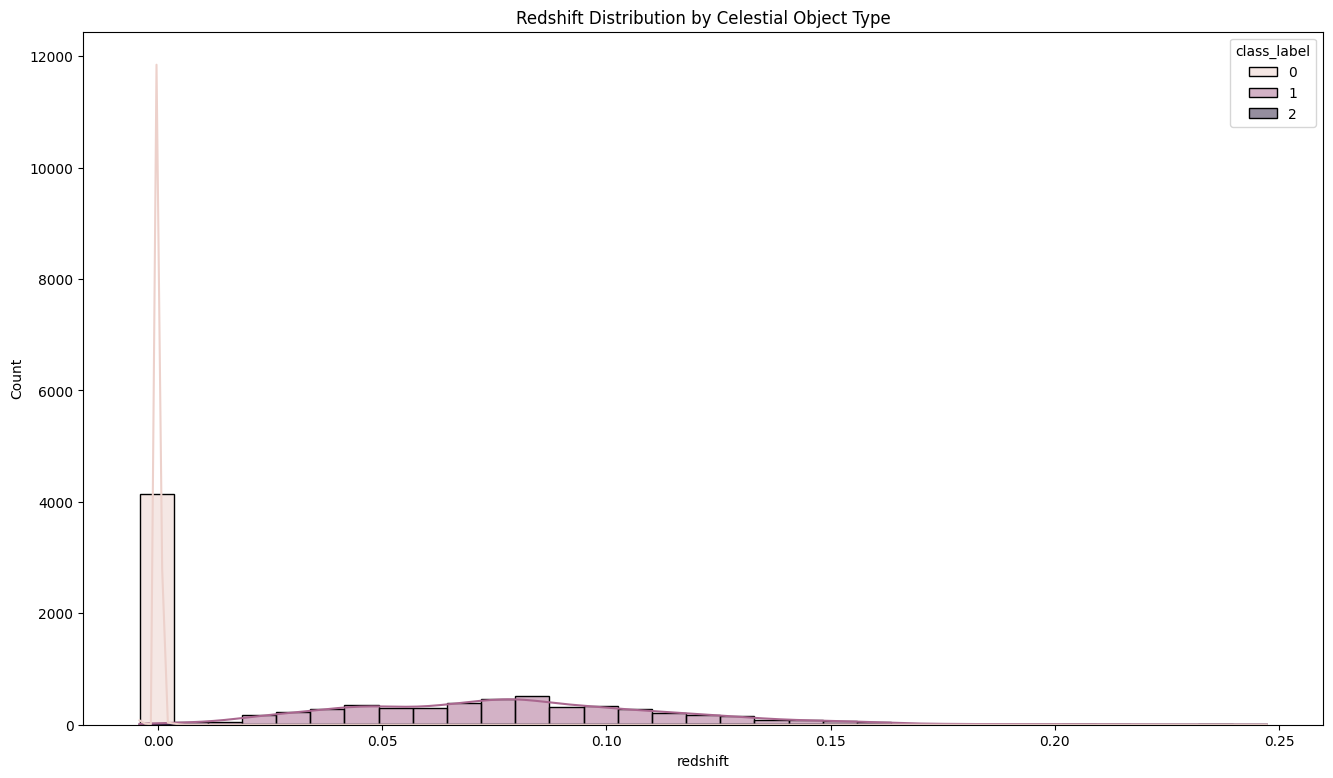

In [ ]:
redshift_data: DataFrame = filtered_data[filtered_data['redshift'] < 0.25]
plt.figure(figsize=(16, 9))
sns.histplot(data=redshift_data, x='redshift', hue='class_label', kde=True)
plt.title(f"Redshift Distribution by Celestial Object Type")
plt.show()

### Correlation Between Features


Correlation Matrix

In [ ]:
filtered_data.corr()

,ra,dec,u,g,r,i,z,redshift,u-g,g-r,r-i,i-z,u-r,class_label
ra,1.000000,0.003596,0.031238,0.043909,0.047103,0.045731,0.042950,0.030307,-0.031264,-0.027832,-0.007848,0.002309,-0.031472,0.041189
dec,0.003596,1.000000,0.035279,0.061875,0.063404,0.058292,0.056870,0.067021,-0.058545,-0.029161,0.004667,-0.007994,-0.049596,0.091249
u,0.031238,0.035279,1.000000,0.849232,0.692379,0.602630,0.551483,0.163741,0.051499,0.201628,0.209199,0.105077,0.115213,0.284541
g,0.043909,0.061875,0.849232,1.000000,0.958106,0.907419,0.879622,0.407576,-0.483585,-0.245873,-0.053364,-0.095263,-0.411698,0.357352
r,0.047103,0.063404,0.692379,0.958106,1.000000,0.977672,0.969197,0.441080,-0.664364,-0.513193,-0.198310,-0.213229,-0.636958,0.278678
i,0.045731,0.058292,0.602630,0.907419,0.977672,1.000000,0.981507,0.431450,-0.717272,-0.589520,-0.399847,-0.167500,-0.702108,0.205367
z,0.042950,0.056870,0.551483,0.879622,0.969197,0.981507,1.000000,0.424034,-0.749486,-0.644133,-0.350555,-0.353126,-0.745087,0.149444
redshift,0.030307,0.067021,0.163741,0.407576,0.441080,0.431450,0.424034,1.000000,-0.499439,-0.271383,-0.088491,-0.075168,-0.432294,0.621046
u-g,-0.031264,-0.058545,0.051499,-0.483585,-0.664364,-0.717272,-0.749486,-0.499439,1.000000,0.799270,0.447718,0.354362,0.969656,-0.204196
g-r,-0.027832,-0.029161,0.201628,-0.245873,-0.513193,-0.589520,-0.644133,-0.271383,0.799270,1.000000,0.511226,0.436158,0.921938,0.127726


<Axes: >

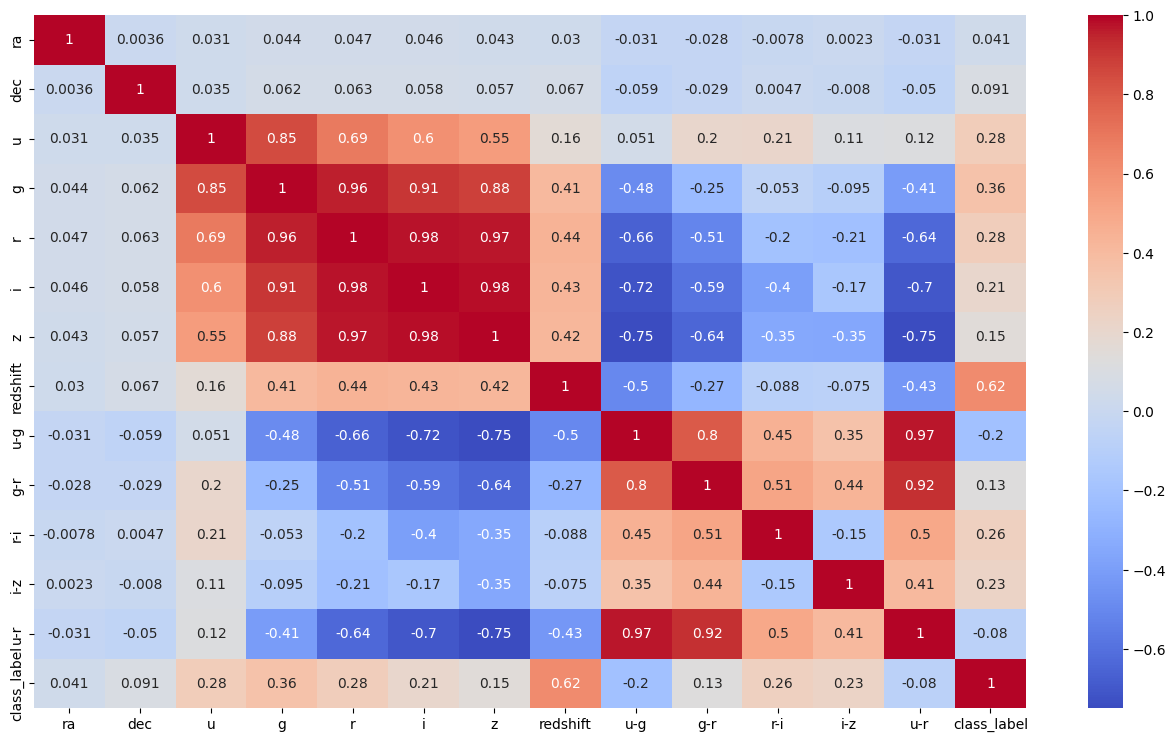

In [ ]:
plt.figure(figsize=(16, 9))
sns.heatmap(filtered_data.corr(), annot=True, cmap='coolwarm') # cmap=Wistia, coolwarm


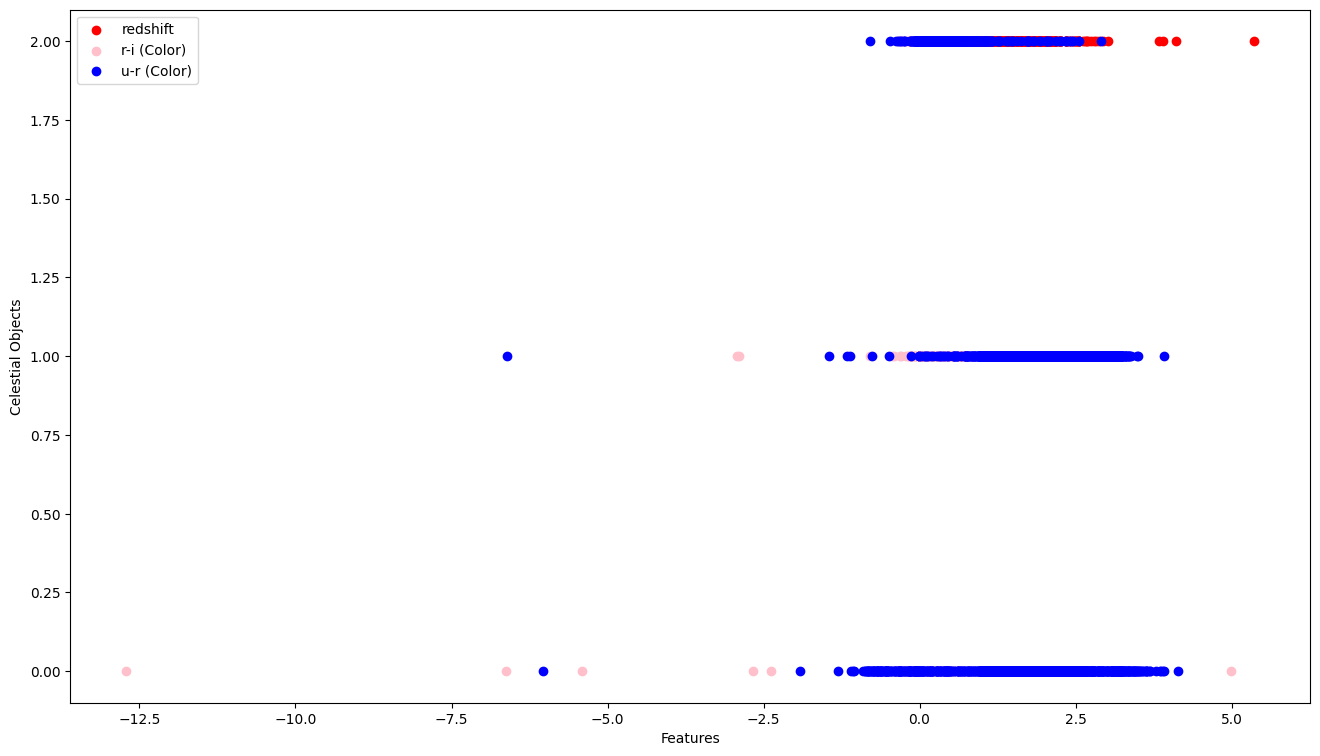

In [ ]:
# Plot the relation of each feature with each species
plt.figure(figsize=(16, 9))
plt.ylabel("Celestial Objects")
plt.xlabel("Features")

plt.scatter(filtered_data['redshift'], filtered_data['class_label'], color='red', label='redshift')
plt.scatter(filtered_data['r-i'], filtered_data['class_label'], color='pink', label='r-i (Color)')
plt.scatter(filtered_data['u-r'], filtered_data['class_label'], color='blue', label='u-r (Color)')
# plt.scatter(filtered_data['petal length (cm)'], filtered_data['class_label'], color='red', label='petal length')
# plt.scatter(filtered_data['petal width (cm)'], filtered_data['class_label'], color='black', label='petal width')


plt.legend()
plt.show()

<Figure size 1600x900 with 0 Axes>

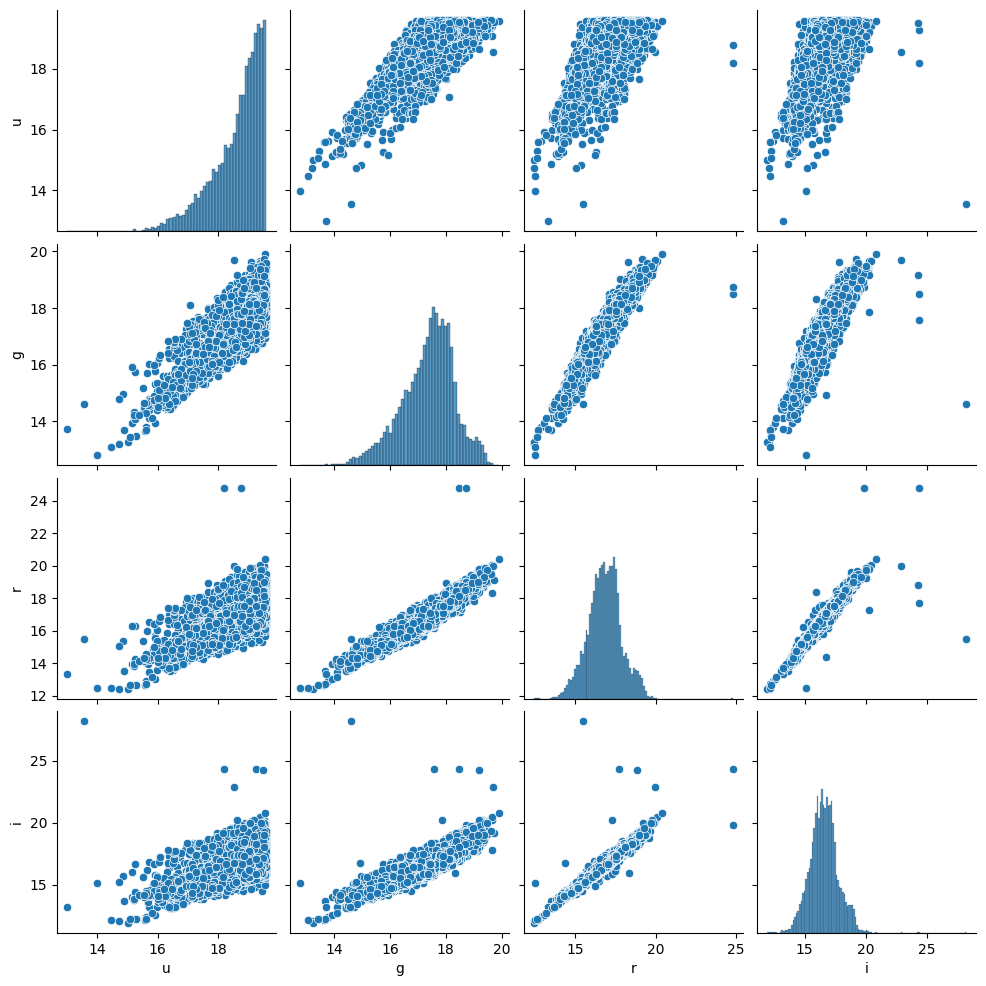

In [ ]:
plt.figure(figsize=(16, 9))

# see all the relation among all the attributes; i.e. relation between e.g. features and target
# sns.pairplot(filtered_data, hue='class_label')

# Using pairplots to establish and understand interdependancy of train features
sns.pairplot(dataframe[['u','g','r','i','class']])

In [ ]:
# categorical plot
# sns.catplot(data=filtered_data, x='redshift', y='g', palette='coolwarm', hue='class_label')

#### Density Distribution Plot

<Axes: xlabel='class_label', ylabel='count'>

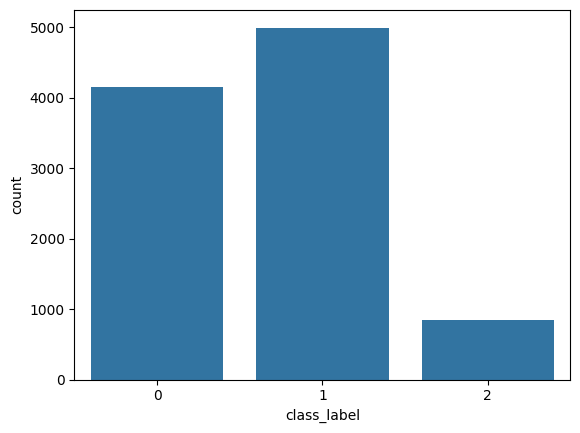

In [ ]:
#Checking the number of labels for each class of the dataset where 0 = Star, 1 = Galaxy, 2 = Quasar.
sns.countplot(x=filtered_data['class_label'])

## Splitting Input and Data Columns

In [ ]:
data: DataFrame = filtered_data.copy()
data['class'] = dataframe['class']
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ra           10000 non-null  float64
 1   dec          10000 non-null  float64
 2   u            10000 non-null  float64
 3   g            10000 non-null  float64
 4   r            10000 non-null  float64
 5   i            10000 non-null  float64
 6   z            10000 non-null  float64
 7   redshift     10000 non-null  float64
 8   u-g          10000 non-null  float64
 9   g-r          10000 non-null  float64
 10  r-i          10000 non-null  float64
 11  i-z          10000 non-null  float64
 12  u-r          10000 non-null  float64
 13  class_label  10000 non-null  int64  
 14  class        10000 non-null  object 
dtypes: float64(13), int64(1), object(1)
memory usage: 1.1+ MB


In [ ]:
features_data: DataFrame = data.iloc[:, :-1]
target_data: DataFrame = data.iloc[:, -1]

#### Splitting into training and testing data

In [ ]:
features_train_data, features_test_data, target_train_data, target_test_data = train_test_split(
    features_data,
    target_data,
    test_size=0.25
)

### Logistic Regression Classifier

Machine learning generally involves predicting a quantitative outcome or a qualitative class. The former is commonly referred to as a regression problem. In the scenario of linear regression, the input is a continuous variable, and the prediction is a numerical value. When predicting a qualitative outcome (class), the task is considered a classification problem. Examples of classification problems include predicting what products a user will buy or if a target user will click on an online advertisement.

Not all algorithms fit cleanly into this simple dichotomy, though, and logistic regression is a notable example. Logistic regression is part of the regression family as it involves predicting outcomes based on quantitative relationships between variables. However, unlike linear regression, it accepts both continuous and discrete variables as input and its output is qualitative. In addition, it predicts a discrete class such as “Yes/No” or “Customer/Non-customer”.

In practice, the logistic regression algorithm analyzes relationships between variables. It assigns probabilities to discrete outcomes using the Sigmoid function, which converts numerical results into an expression of probability between 0 and 1.0. Probability is either 0 or 1, depending on whether the event happens or not. For binary predictions, you can divide the population into two groups with a cut-off of 0.5. Everything above 0.5 is considered to belong to group A, and everything below is considered to belong to group B.

In [ ]:
model_lr = LogisticRegression()

### Support Vector Machine Classifier

Each object to be classified is represented as a point in an n-dimensional space; and the coordinates of that point are usually called features. SVM perform classification task by drawing a hyperplane i.e a line in 2D or a place in 3D; in such a way that all points of one category are on one side of the hyperplace and all points of the other category are on the other side.

SVM works to maximise the distance to points in either category, a distance known as the **margin**. Points that fall exactly at the margin are called the *supporting vectors*.


In [ ]:
model_sv = SVC()

### Decision Tree Classifier

The decision of making strategic splits heavily affects a tree’s accuracy. The decision criteria are different for classification and regression trees.

Decision trees use multiple algorithms to decide to split a node into two or more sub-nodes. The creation of sub-nodes increases the homogeneity of resultant sub-nodes. In other words, we can say that the purity of the node increases with respect to the target variable. The decision tree splits the nodes on all available variables and then selects the split which results in most homogeneous sub-nodes.



In [ ]:
model_dt = DecisionTreeClassifier(max_leaf_nodes=15,max_depth=3)

### K-Nearest Neighbours Classifier

The KNN algorithm assumes that similar things exist in close proximity. In other words, similar things are near to each other.

“Birds of a feather flock together.”

Image showing how similar data points typically exist close to each other Notice in the image above that most of the time, similar data points are close to each other. The KNN algorithm hinges on this assumption being true enough for the algorithm to be useful. KNN captures the idea of similarity (sometimes called distance, proximity, or closeness) with some mathematics we might have learned in our childhood— calculating the distance between points on a graph.

In [ ]:
model_kn = KNeighborsClassifier(n_neighbors=3)

In [ ]:
# Fitting the models to the dataset
model_lr.fit(features_train_data, target_train_data)
model_sv.fit(features_train_data, target_train_data)
model_dt.fit(features_train_data, target_train_data)
model_kn.fit(features_train_data, target_train_data)

/home/karoki/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


KNeighborsClassifier(n_neighbors=3)

In [ ]:
#Getting the prediction set of the models
prediction_lr: ndarray = model_lr.predict(features_test_data)
prediction_sv: ndarray = model_sv.predict(features_test_data)
prediction_dt: ndarray = model_dt.predict(features_test_data)
prediction_kn: ndarray = model_kn.predict(features_test_data)

#### Results

In [ ]:

lr_score: float = model_lr.score(features_test_data, target_test_data)
print(f"Logistic Regression Accuracy Score: {lr_score * 100}%")

print(accuracy_score(target_test_data, prediction_lr)*100, "\b%")

Logistic Regression Accuracy Score: 98.8%
98.8%


### Classification Report

Evaluation Metrics:
- **Precision** - ratio of true positives to predicted positives
- **Recall** - number of true positives the model correctly identifies
- **f1-score** - harmonic mean of precision and recall

In [ ]:
# Classification Report
target_names = ['0', '1', '2']

print("Logistic Regression \n", classification_report(target_test_data, prediction_lr, target_names=target_names))
print("Support Vector Machine \n", classification_report(target_test_data, prediction_sv, target_names=target_names))
print("Decision Tree \n", classification_report(target_test_data, prediction_dt, target_names=target_names))
print("K-Nearest Neaighbout \n", classification_report(target_test_data, prediction_kn, target_names=target_names))

Logistic Regression 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1225
           1       0.99      0.88      0.93       215
           2       1.00      1.00      1.00      1060

    accuracy                           0.99      2500
   macro avg       0.99      0.96      0.97      2500
weighted avg       0.99      0.99      0.99      2500

Support Vector Machine 
               precision    recall  f1-score   support

           0       0.50      0.96      0.65      1225
           1       0.00      0.00      0.00       215
           2       0.52      0.06      0.11      1060

    accuracy                           0.50      2500
   macro avg       0.34      0.34      0.25      2500
weighted avg       0.46      0.50      0.37      2500

Decision Tree 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1225
           1       1.00      1.00      1.00       215
           2

/home/karoki/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karoki/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karoki/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
